In [17]:
import numpy as np
import pandas as pd
import math 
import pdb

import nbimporter
from PreisOrderBook import PreisOrderBook


class PreisModel:
    # Single complete Preis model iteration
    
    # Attributes
    def __init__(self, N_A, delta, lambda_0, C_lambda, delta_S, p_0, alpha, mu, T, MC, ranSeq):
        # Trader population attributes:
        self.N_A = N_A               # number of liquidity providers = takers = N_A
        
        # Trade order cancellation attributes
        self.delta = delta           # Limit order probability cancellation
        
        # Liquidity provider order placement attributes
        self.lambda_0 = lambda_0     # initial order placement depth 
        self.lambda_t = None     # current order placement depth
        self.C_lambda = C_lambda     # placement depth coefficient
        
        # Trader buy/sell decision attributes
        self.q_provider = None # =0.5 (constant) buy probability of liquidity providers
        self.q_taker = None       # buy probability of liquidity takers (mean 0.5)
        self.q_mean_dev = None # variance of q_taker
        self.delta_S = delta_S       # liquidity taker buy probability random walk increment 
        
        # Order Book attributes
        self.limitOrderBook = None
        
        # Price time series attributes
        self.intradayPrice = np.zeros((T,1)) # Timeseries of intraday prices (mid-prices)
        self.p_0 = p_0                     # initial price value
        
        # Trader activation frequency attributes
        self.alpha = alpha                 # activation frequency for liquidity providers
        self.mu = mu                       # activation frequency for liquidity takers
        
        # Simulation attributes
        self.T = T                         # timehorizon
        self.MC = MC                       # MC steps to estimate standard dev of q_taker
        self.tradeSigns = []     # series of trade signs
        self.ranSeq = ranSeq
        self.u01 = None
        
# Update limit order buy probability
    def incrementTakerRandomWalk(self):
        q_current = self.q_taker
        
        # mean reversion probability
        p_revert = 0.5 + abs(q_current - 0.5)
        
        # Up probability
        if q_current < 0.5:
            
            # below the mean, up move more likely:
            p_up = p_revert
        
        else:
            p_up = 1-p_revert

        
        if self.u01 <= p_up:
            self.q_taker = q_current + self.delta_S
        else:
            self.q_taker = q_current - self.delta_S
        
    # Construct Preis
    # Requires incrementTalkerRandomWalk function and PreisOrderBook class
    def simRun(self):
        # requires the following methods:
            # incrementTalkerRandomWalk
            # Preis order book
        
        self.lambda_t = self.lambda_0
        self.C_lambda = self.C_lambda
        
        self.q_provider = 1/2
        self.q_taker = 1/2

        
        self.q_taker_sim = np.zeros((self.MC,1))
        
        for i in range(self.MC):
            self.u01 = self.ranSeq[0]
            self.ranSeq = self.ranSeq[1:]
            self.incrementTakerRandomWalk()
            self.q_taker_sim[i,] = self.q_taker - 0.5

        
        self.q_mean_dev = np.dot(self.q_taker_sim.T, self.q_taker_sim) / self.MC
        
        # reset q_taker
        self.q_taker = 1/2
        
        self.limitOrderBook = PreisOrderBook()
        #self.limitOrderBoook = PreisOrderBook()
        self.limitOrderBook.bestAsk = self.p_0
        self.limitOrderBook.bestBid = self.p_0
        
        self.intradayPrice = np.zeros((self.T,1))
        #self.p_0 = p_0
        
        #self.alpha = alpha
        #self.mu = mu
        
        #self.T = T
        #self.tradeSigns = []
        
    def calcProviderLimitPrice(self, u01, u02):
        # function to determine limit order price
        
        # buy rand <= q_provider then buy
        if u01 <= self.q_provider:
            
            eta = math.floor(-self.lambda_t* math.log(u02))
            
            # set buy limit price
           
            limitPrice = self.limitOrderBook.bestAsk - 1 - eta

            # set buy flag
            buyFlag = 1
        
        else:
            
            eta = math.floor(-self.lambda_t * math.log(u02))
            
            # set sell limit price
            limitPrice = self.limitOrderBook.bestBid + 1 + eta
            
            # set sell flag
            buyFlag = 0
        
        return([limitPrice, buyFlag])
    
    def incrementPlacementDepth(self):
        # Increment order placement depth
        
        # current buy probability of liquidity taker
        q_current = self.q_taker
        
        # calculate new placement depth
        self.lambda_t = self.lambda_0 * (1 + abs(q_current - 0.5)/ math.sqrt(self.q_mean_dev) * self.C_lambda)
        
    
    def placeOrder(self, traderType, u01, u02):
        # function to place a limit order
        
        orderSize = 1 # model default
        
        # differentiate between trader types (provider and taker)
        if traderType == 1: # liquidity provider (limit order)
            [limitPrice,buyFlag]  = self.calcProviderLimitPrice(u01, u02) 
            #bestBid for LOs not updating properly silly 
            # place limit order
            self.limitOrderBook.limitOrder(buyFlag,orderSize,limitPrice)
            

        else: # taker (market order)
            
            # buyer
            if u01 <= self.q_taker:
                
                # buyer
                buyFlag = 1
                
                # Update trade sign series
                self.tradeSigns.append(1)
                
            else: #seller
                
                #seller:
                buyFlag = 0
                
                #Update trade sign series
                self.tradeSigns.append(-1)
            
            # place market order
            self.limitOrderBook.marketOrder(buyFlag, orderSize)
            

                
    def initialize(self):
        # initialise simulation
        # fill orderbook before trading starts with LOs
        
        # Extract random numbers for placing limit orders
        numInit = math.floor(self.N_A*10*self.alpha)
        
        for i in range(numInit): # num traders *10* rate of trading
            
            # place orders
            u01 = self.ranSeq[0]
            u02 = self.ranSeq[1]
            self.ranSeq = self.ranSeq[2:]
            self.placeOrder(1, u01, u02) # 1 being provider
        
            
    def simulate(self):
        # simulate trading for T MC steps 
        
        # simulate intial orders of:
        numLimitOrders = math.floor(self.N_A*self.alpha)
        numMarketOrders = math.floor(self.N_A*self.mu)
        
        # simulate time series of T MC steps
        for i in range(self.T):
                      
            # providers place new Limit Orders
            for j in range(numLimitOrders):
                
                # Random numbers extract
                u01 = self.ranSeq[0]
                u02 = self.ranSeq[1]
                self.ranSeq = self.ranSeq[2:]
                
                # place Limit Order
                
                self.placeOrder(1, u01, u02)
                
            # takers place new market orders
            for j in range(numMarketOrders):
                
                # Random numbers extract
                u01 = self.ranSeq[0]
                self.ranSeq = self.ranSeq[1:]
                
                # place market order
                self.placeOrder(2, u01, u01)
            
            
            # Random numbers extract
            uSeq = self.ranSeq[:self.limitOrderBook.orderBook.shape[0]]
            self.ranSeq = self.ranSeq[self.limitOrderBook.orderBook.shape[0]:]
            
            # determine orders to be kept: (if greater than delta then avoids removing)
            keepIndices = uSeq > self.delta
        
            # update number of buy orders
            self.limitOrderBook.numBuy = self.limitOrderBook.numBuy - sum(
            np.array(self.limitOrderBook.orderBook["limitOrderType"].iloc[keepIndices==0] == 2))
        
            # update number of sell orders
            self.limitOrderBook.numSell = self.limitOrderBook.numSell - sum(
            self.limitOrderBook.orderBook["limitOrderType"].iloc[keepIndices ==0] == 1)
        
            # cancel orders
            self.limitOrderBook.orderBook = self.limitOrderBook.orderBook.iloc[keepIndices==1,]
        
        
            # update best bid
            if self.limitOrderBook.numBuy != 0:
                self.limitOrderBook.bestBid = self.limitOrderBook.orderBook["limitOrderPrice"].iloc[(self.limitOrderBook.numBuy-1)]
            else:
                self.limitOrderBook.bestBid = 0

            # update best ask
            if self.limitOrderBook.numSell != 0:
                self.limitOrderBook.bestAsk = self.limitOrderBook.orderBook["limitOrderPrice"].iloc[self.limitOrderBook.numBuy]
            else:
                self.limitOrderBook.bestAsk = 0 

            # Update price (mid-price)
            #pdb.set_trace()
            if (self.limitOrderBook.bestBid !=0) & (self.limitOrderBook.bestAsk !=0):
                self.intradayPrice[i,] = (self.limitOrderBook.bestBid + self.limitOrderBook.bestAsk)/2
            elif i>0:
                self.intradayPrice[i,] = self.intradayPrice[(i-1),]
            else:
                self.intradayPrice[i,] = self.p_0

            # update taker buy probability
            # Random numbers extract
            self.u01 = self.ranSeq[0]
           
            self.ranSeq = self.ranSeq[1:]
            self.incrementTakerRandomWalk()

            # update order placement depth
            self.incrementPlacementDepth()
        
    
    def sampleAutoCorrelation(self, series, lags):
        # autocorrelaion for a given series and a desired number of lags
        
        # data structure to store ACF
        acf = np.zeros(lags, 1)
        
        # series sample mean
        mu_hat = np.mean(series)
        
        # repeat for desired number of lags
        for i in range(lags):
            
            # calculate sample acf
            acf[i, 1] = sum((series[i:]-mu_hat) * (series[:-i]-mu_hat)/sum(series-mu_hat)^2)

        

        

    

In [18]:
np.random.seed(1)
ran_seq_df = pd.read_csv('ran3.csv', header=None) # seed =1



In [19]:
ran_seq = ran_seq_df[0].values

In [20]:
p=PreisModel(N_A = 125, delta = 0.025, lambda_0 =100, C_lambda = 10, 
                    delta_S=0.001, alpha=0.15, mu=0.025, p_0=100, T=250, MC=10**5, ranSeq = ran_seq)


        

In [21]:
p.simRun() # matches Matlab
p.q_mean_dev # matches Matlab



array([[0.00025772]])

In [22]:
#pdb.set_trace()

In [23]:
p.initialize()


In [24]:
p.limitOrderBook.bestAsk # matched initial order book
#p.limitOrderBook.numBuy
p.limitOrderBook.orderBook.loc[p.limitOrderBook.orderBook["limitOrderType"]==1]
p.limitOrderBook.orderBook
p.limitOrderBook.numBuy
p.limitOrderBook.bestAsk


100

In [25]:
p.limitOrderBook.numSell # matched

87

In [26]:
p.limitOrderBook.numBuy # matched

100

In [27]:
p.simulate()




In [29]:
[p.limitOrderBook.bestAsk, p.limitOrderBook.bestBid]

[134, 35]

In [30]:
[p.limitOrderBook.numBuy, p.limitOrderBook.numSell]

[292, 282]

In [31]:
p.limitOrderBook.orderBook.shape


(574, 4)

In [32]:
p.intradayPrice

array([[100.5],
       [104. ],
       [103.5],
       [104. ],
       [104.5],
       [104. ],
       [102.5],
       [103.5],
       [103.5],
       [102.5],
       [103. ],
       [ 93.5],
       [101.5],
       [102. ],
       [101.5],
       [104.5],
       [105. ],
       [ 96. ],
       [ 98. ],
       [ 92.5],
       [ 91.5],
       [ 95.5],
       [ 94.5],
       [108. ],
       [101.5],
       [106. ],
       [116.5],
       [118.5],
       [112.5],
       [107. ],
       [106.5],
       [127. ],
       [126. ],
       [127.5],
       [128. ],
       [128.5],
       [109.5],
       [ 96. ],
       [ 94.5],
       [ 96. ],
       [ 89. ],
       [104.5],
       [107. ],
       [ 99. ],
       [104. ],
       [109. ],
       [ 90.5],
       [118. ],
       [118. ],
       [118. ],
       [118. ],
       [118. ],
       [119. ],
       [119.5],
       [131.5],
       [139. ],
       [134. ],
       [125. ],
       [120.5],
       [121.5],
       [116. ],
       [133. ],
       [

In [33]:
p.limitOrderBook.orderBook

,limitOrderSize,limitOrderPrice,limitOrderType,tradeFlag
0,1,-7558,2,0
1,1,-6464,2,0
2,1,-3547,2,0
3,1,-3434,2,0
4,1,-2792,2,0
5,1,-2758,2,0
6,1,-2742,2,0
7,1,-2333,2,0
8,1,-2286,2,0
9,1,-2280,2,0


In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.DataFrame(p.intradayPrice, columns = ["Intraday Price"])


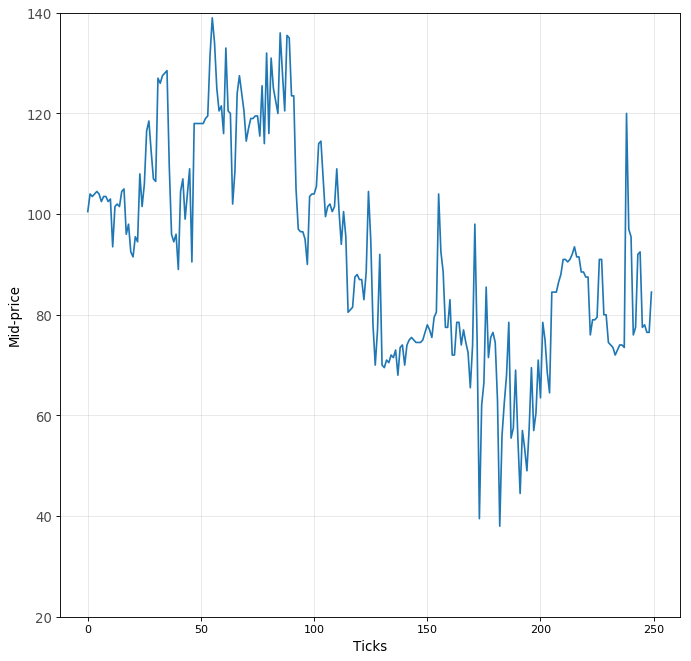

In [59]:
# Draw Plot
plt.figure(figsize=(10,10), dpi= 80)
plt.plot('Intraday Price', data=df, color='tab:blue')

# Decoration
plt.ylim(20, 140)
xtick_location = df.index.tolist()[::12]
#xtick_labels = [x[-4:] for x in df.date.tolist()[::12]]
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
#plt.title("Reproduced Intraday Price Simulation", fontsize=22)
plt.grid(axis='both', alpha=.3)

# Remove borders
#plt.gca().spines["top"].set_alpha(0.0)    
#plt.gca().spines["bottom"].set_alpha(0.3)
#plt.gca().spines["right"].set_alpha(0.0)    
#plt.gca().spines["left"].set_alpha(0.3)   
plt.gca().set(xlabel='Ticks', ylabel='Mid-price')
plt.ylabel("Mid-price", fontsize=12)
plt.xlabel("Ticks", fontsize=12)
plt.show()

